In [1]:
import matplotlib.pyplot as plt
import sys

from validphys.api import API

# Add the path to the library folder
sys.path.append('./lib')

from utils import XGRID, build_fk_matrix, regularize_matrix
from model import PDFmodel, generate_mse_loss
from gen_dicts import generate_dicts
from plot_utils import plot_eigvals
from validphys.api import API

import numpy as np
import pandas as pd

#set seed 
seed = 14132124 

Using Keras backend


In [2]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{#'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
FK = build_fk_matrix(fk_table_dict)

print('shape of the (FK) table: ', FK.shape)


shape of the (FK) table:  (1208, 450)


In [3]:
# Function to check if a matrix is symmetric with a tolerance
def is_symmetric(matrix, tol=1e-9):
    return np.allclose(matrix, matrix.T, atol=tol)

# Function to check if a matrix is an identity matrix
def is_identity_matrix(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # Create an identity matrix of the same size as the input matrix
    identity_matrix = np.eye(matrix.shape[0])
    
    # Check if the matrix is equal to the identity matrix
    return np.allclose(matrix, identity_matrix)

# Function to check if the matrix is diagonal
def is_diagonal(matrix, tol):
    # Extract the diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Create a matrix where all diagonal elements are set to zero
    non_diagonal_elements = matrix - np.diag(diagonal_elements)
    
    # Check if all non-diagonal elements are zero
    return np.all(abs(non_diagonal_elements)<tol)

# Function to check if the matrix is orthogonal
def is_orthogonal(matrix, tol=1e-9):
    # Compute the transpose of the matrix
    transpose = matrix.T
    
    # Multiply matrix by its transpose
    product = np.dot(matrix, transpose)
    
    # Check if the product is close to the identity matrix
    identity = np.eye(matrix.shape[0])
    
    # Check if all elements are within the tolerance level
    return np.allclose(product, identity, atol=tol)

def is_positive_definite(matrix):
    try:
        # Attempt the Cholesky decomposition
        _ = np.linalg.cholesky(matrix)
        return True  # If no error, it's positive definite
    except np.linalg.LinAlgError:
        return False  # If error occurs, it's not positive definite

def is_positive_definite_eigenvalues(matrix,tol=1.e-9):
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    # Check if all eigenvalues are positive
    return np.allclose(eigenvalues, np.maximum(eigenvalues,0),atol=tol)


In [4]:
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C_index = C.index
C_col = C.columns

print('condition number of the covariance matrix: ', np.linalg.cond(C))
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

is_identity_matrix(Cinv@C)
is_identity_matrix(C@Cinv)

# Diagonalize the inverse covariance matric
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.zeros_like(R_Y)
np.fill_diagonal(D_Y, eigvals_Cinv)

# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError
  
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

tol = np.finfo(np.float64).eps #None #np.finfo(np.float64).eps


LHAPDF 6.5.4 loading /Users/ldeldebb/miniconda3/envs/nnpdf-dev/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100
condition number of the covariance matrix:  3084545.0459413906


In [5]:
np.linalg.cond(Cinv)

3084545.0459414255

In [6]:
# Constructing the matrix M

M = FK.T @ Cinv.to_numpy() @ FK
print('check that M is symmetric and positive: ', is_symmetric(M),' ', is_positive_definite_eigenvalues(M,1e-10))


check that M is symmetric and positive:  True   True


size of vectors:  450
matrix form  1.6396913588973113e-10
Max eigenvalue:  34359.97124075823


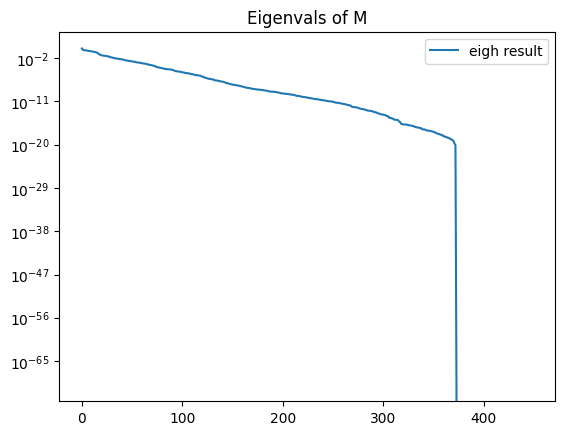

In [7]:
# Compute the eigensystem using np.linalg.eigh

eigenvalues, eigenvectors = np.linalg.eigh(M)
eigenvalues = eigenvalues[::-1]
eigenvectors_reordered = eigenvectors[:, ::-1]

#test the eigenvectors
print('size of vectors: ', eigenvalues.size)
for i in range(eigenvalues.size):
    if np.linalg.norm(M@eigenvectors_reordered.T[i]-eigenvalues[i]*eigenvectors_reordered.T[i]) > 1.e-10:
        print(i, ' ', np.linalg.norm(M@eigenvectors_reordered.T[i]-eigenvalues[i]*eigenvectors_reordered.T[i]))

print('matrix form ', np.linalg.norm(M@eigenvectors_reordered-eigenvalues*eigenvectors_reordered,ord=np.inf))

print('Max eigenvalue: ', eigenvalues[0])

plt.plot(eigenvalues/eigenvalues[0],label='eigh result')
plt.legend()
plt.yscale('log')
plt.title('Eigenvals of M')
plt.show()

Check that the sing values correspond to the e.vals:  True
Check that U=V:  False
Check that U=R:  False
Check that U and V are orthogonal:  True   True


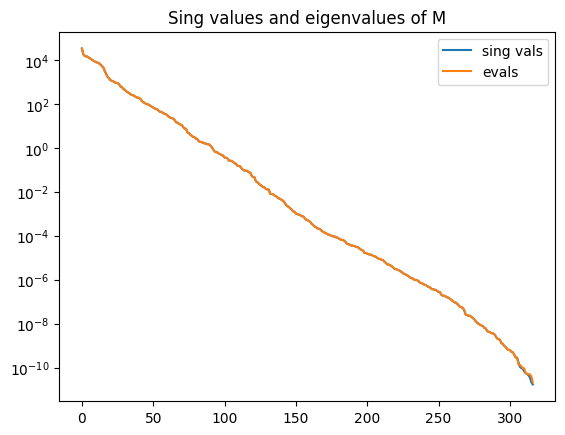

In [17]:
# SVD decomposition of M

MU,MS,MVT = np.linalg.svd(M)

print('Check that the sing values correspond to the e.vals: ', np.allclose(MS[MS > 2*tol * MS[0]],eigenvalues[eigenvalues > 2.5*tol * eigenvalues[0]]))
print('Check that U=V: ', np.allclose(MU,MVT.T))
print('Check that U=R: ', np.allclose(eigenvectors,MU))
print('Check that U and V are orthogonal: ', is_orthogonal(MU), ' ', is_orthogonal(MVT))

plt.plot(MS[MS > 5.0e-16 * MS[0]],label='sing vals')
plt.plot(eigenvalues[eigenvalues > 5.e-16 * eigenvalues[0]],label='evals')
plt.legend()
plt.yscale('log')
plt.title('Sing values and eigenvalues of M')
plt.show()

163
173
dim of the subspace orthogonal to ker(M):  163


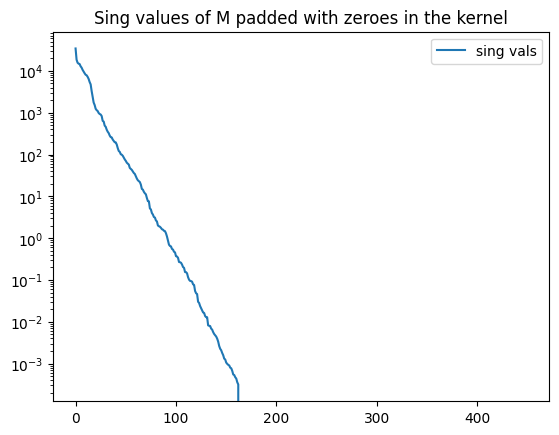

In [19]:
#determination of the size of the kernel within the statistical noise
i=0
while np.allclose(MU[:,:i],MVT.T[:,:i]):
    i=i+1
Nvect1=i
print(Nvect1)

i=0
while np.allclose(np.abs(MU[:,:i]),np.abs(eigenvectors_reordered[:,:i])):
    i=i+1
Nvect2=i
print(Nvect2)

if Nvect1 <= Nvect2: 
    Nvect = Nvect1
else:
    Nvect = Nvect2

MSpad = MS
MSpad[Nvect:] = 0
print('dim of the subspace orthogonal to ker(M): ',Nvect)
plt.plot(MSpad,label='sing vals')
plt.legend()
plt.yscale('log')
plt.title('Sing values of M padded with zeroes in the kernel')
plt.show()

In [39]:
MSpinv = np.linalg.pinv(np.diag(MS))
for i in range(MS.size):
    print(i, MS[i], 1/MS[i], MSpinv[i,i])

0 34359.97124075823 2.9103633207171825e-05 2.9103633207171825e-05
1 18493.344480527416 5.407350742062643e-05 5.407350742062643e-05
2 15683.930579804231 6.375952730163653e-05 6.375952730163653e-05
3 14901.87308424991 6.710565808380962e-05 6.710565808380962e-05
4 14629.533982606688 6.835487727694659e-05 6.835487727694659e-05
5 12903.240570611722 7.749991132286481e-05 7.74999113228648e-05
6 11965.585334724887 8.35730114345461e-05 8.35730114345461e-05
7 10584.645009459067 9.447647975972181e-05 9.447647975972181e-05
8 9595.68580532255 0.00010421349972143924 0.00010421349972143924
9 8788.241795603519 0.00011378840310245772 0.00011378840310245772
10 8099.910112201912 0.00012345816017063872 0.00012345816017063872
11 7854.915257939009 0.00012730882093085524 0.00012730882093085524
12 7210.6108654203945 0.0001386845051915997 0.0001386845051915997
13 6431.337349336074 0.0001554886558863582 0.0001554886558863582
14 5421.393414899682 0.0001844544240695921 0.0001844544240695921
15 4776.026373476952 0

/var/folders/8z/v4hzb9f95tn0y4yc27tssntr0000gn/T/ipykernel_8609/3297232908.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  print(i, MS[i], 1/MS[i], MSpinv[i,i])


In [48]:
MVT_orth = MVT[:Nvect,:]
MS_orth = MS[:Nvect]
print('dim of the orth matrix: ', MVT_orth.shape)
print('dim of the orth evals: ', MS_orth.size)

dim of the orth matrix:  (163, 450)
dim of the orth evals:  163


In [49]:
def Minv(f_in):
    #Temporarily suppress the divide by zero warning
    np.seterr(divide='ignore', invalid='ignore')

    MSpad_inv = np.where(MSpad != 0, 1. / MSpad, 0)

    # Reset the numpy error settings to default
    np.seterr(divide='warn', invalid='warn')
    
    return MVT.T @ np.diag(MSpad_inv) @ MVT @ f_in

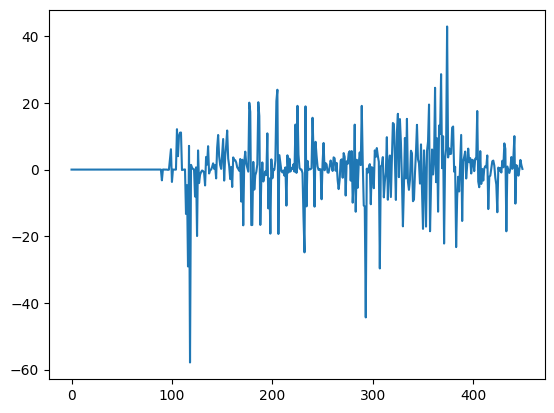

In [50]:
 finf = Minv(FK.T @ Cinv @ Y)
plt.plot(finf)

In [42]:
def Tilde_rot(f_in):
    return np.diag(np.sqrt(MSpad)) @ MVT @ f_in

def Tilde_inv(f_in):
    # Temporarily suppress the divide by zero warning
    np.seterr(divide='ignore', invalid='ignore')

    MSpad_inv = np.where(MSpad != 0, 1. / MSpad, 0)

    # Reset the numpy error settings to default
    np.seterr(divide='warn', invalid='warn')
    
    return MVT.T @ np.diag(np.sqrt(MSpad_inv)) @ f_in

In [43]:
#construct b
ntk=NTK_flat
b = ntk @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy('float64')
print(b.shape)
btilde = Tilde_rot(b.squeeze())
print(btilde.shape)
#plt.plot(b_tilde)

(450, 1)
(450,)


check that the NTK is symmetric:  True


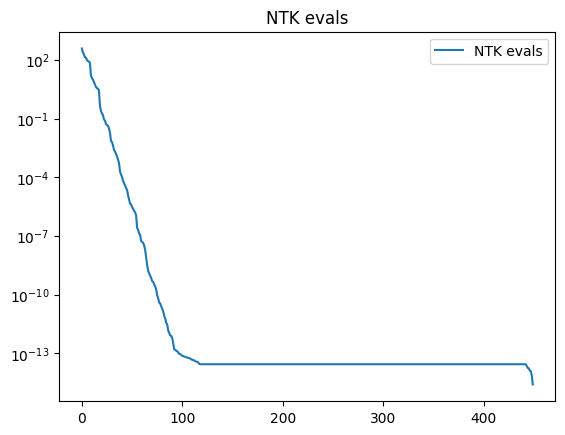

In [44]:
#SVD of the ntk
NTK_U, NTK_S, NTK_VT = np.linalg.svd(NTK_flat)
print('check that the NTK is symmetric: ', is_symmetric(NTK_flat))
plt.plot(NTK_S, label='NTK evals')
plt.legend()
plt.yscale('log')
plt.title('NTK evals')
plt.show()

check that Htilde is symmetric:  True


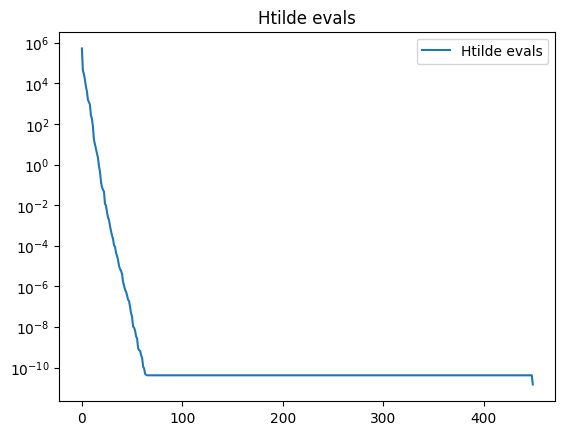

In [45]:
#construct \tilde{H} and find its SVD
Htilde = np.diag(np.sqrt(MSpad))@MVT@NTK_flat@MVT.T@np.diag(np.sqrt(MSpad))
print('check that Htilde is symmetric: ', is_symmetric(Htilde))
HtildeU,HtildeS,HtildeVT = np.linalg.svd(Htilde)
plt.plot(HtildeS, label='Htilde evals')
plt.legend()
plt.yscale('log')
plt.title('Htilde evals')
plt.show()

dim of the subspace orthogonal to ker(Htilde):  33


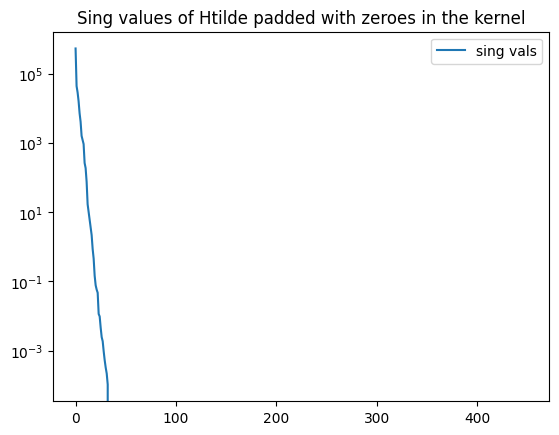

In [46]:
#determination of the size of the kernel of Htilde within statistical noise
i=0
while np.allclose(HtildeU[:,:i],HtildeVT.T[:,:i]):
    i=i+1
Htildevect=i

HtildeSpad = HtildeS
HtildeSpad[Htildevect:] = 0
print('dim of the subspace orthogonal to ker(Htilde): ',Htildevect)
plt.plot(HtildeSpad,label='sing vals')
plt.legend()
plt.yscale('log')
plt.title('Sing values of Htilde padded with zeroes in the kernel')
plt.show()


In [47]:
HtildeVT_orth = HtildeVT[:Htildevect,:]
HtildeS_orth = HtildeS[:Htildevect]
print('dim of the orth matrix: ', HtildeVT_orth.shape)
print('dim of the orth evals: ', HtildeS_orth.size)

dim of the orth matrix:  (33, 450)
dim of the orth evals:  33
